In [17]:
import sys
sys.path.append('..')
import h5py
import jax
import yaml
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../flowrec/utils/a4.mplstyle')

from ml_collections import config_dict
from pathlib import Path

import flowrec.data as data_utils
import flowrec.physics_and_derivatives as derivatives
import flowrec.training_and_states as state_utils
from flowrec import losses
from flowrec.utils import simulation2d
from flowrec.utils.py_helper import slice_from_tuple

In [18]:
def get_loss_one_case(folder):
    with open(Path(folder,'config.yml'),'r') as f:
        cfg = yaml.load(f, Loader=yaml.UnsafeLoader)
        cfg.data_config.data_dir = '.'+cfg.data_config.data_dir
        rng = np.random.default_rng(cfg.data_config.randseed)

    x_base = 132
    triangle_base_coords = [49,80]
    (ux,uy,pp) = simulation2d.read_data(cfg.data_config.data_dir,x_base)
    x = np.stack([ux,uy,pp],axis=0)
    # remove parts where uz is not zero
    s = slice_from_tuple(cfg.data_config.slice_to_keep)
    x = x[s]

    [x_train,x_val,x_test], _ = data_utils.data_partition(x,
        1,
        cfg.data_config.train_test_split,
        REMOVE_MEAN=cfg.data_config.remove_mean,
        SHUFFLE=cfg.data_config.shuffle
    ) # Do not shuffle, do not remove mean for training with physics informed loss

    [ux_train,uy_train,pp_train] = np.squeeze(np.split(x_train,3,axis=0))
    [ux_val,uy_val,pp_val] = np.squeeze(np.split(x_val,3,axis=0))
    [ux_test,uy_test,pp_test] = np.squeeze(np.split(x_test,3,axis=0))

    datainfo = data_utils.DataMetadata(
        re = cfg.data_config.re,
        discretisation=[cfg.data_config.dt,cfg.data_config.dx,cfg.data_config.dy],
        axis_index=[0,1,2],
        problem_2d=True
    ).to_named_tuple()

    u_train = np.stack((ux_train,uy_train,pp_train),axis=-1)
    u_test = np.stack((ux_test,uy_test,pp_test),axis=-1)

    std_data = np.std(x,axis=(1,2,3),ddof=1)
    std_n = data_utils.get_whitenoise_std(cfg.data_config.snr,std_data)
    noise_ux = rng.normal(scale=std_n[0],size=x[0,...].shape)
    noise_uy = rng.normal(scale=std_n[1],size=x[1,...].shape)
    noise_pp = rng.normal(scale=std_n[2],size=x[2,...].shape)
    noise = np.stack([noise_ux,noise_uy,noise_pp],axis=0)
    x_noisy = x + noise

    [x_train_n,x_val_n,x_test_n], _ = data_utils.data_partition(x_noisy,
        1,
        cfg.data_config.train_test_split,
        REMOVE_MEAN=cfg.data_config.remove_mean,
        randseed=cfg.data_config.randseed,
        SHUFFLE=cfg.data_config.shuffle
    ) # Do not shuffle, do not remove mean for training with physics informed loss
    [ux_train_n,uy_train_n,pp_train_n] = np.squeeze(np.split(x_train_n,3,axis=0))
    [ux_val_n,uy_val_n,pp_val_n] = np.squeeze(np.split(x_val_n,3,axis=0))
    [ux_test_n,uy_test_n,pp_test_n] = np.squeeze(np.split(x_test_n,3,axis=0))

    ## normalise
    if cfg.data_config.normalise:
        [ux_train_normal_n,uy_train_normal_n,pp_train_normal_n], train_minmax = data_utils.normalise(ux_train_n,uy_train_n,pp_train_n)
        [ux_val_normal_n,uy_val_normal_n,pp_val_normal_n], val_minmax = data_utils.normalise(ux_val_n,uy_val_n,pp_val_n)
        [ux_test_normal_n,uy_test_normal_n,pp_test_normal_n], test_minmax = data_utils.normalise(ux_test_n,uy_test_n,pp_test_n)
        ## take input
        pb_train = simulation2d.take_measurement_base(pp_train_normal_n,ly=triangle_base_coords,centrex=0)
        pb_val = simulation2d.take_measurement_base(pp_val_normal_n,ly=triangle_base_coords,centrex=0)
        pb_test = simulation2d.take_measurement_base(pp_test_normal_n,ly=triangle_base_coords,centrex=0)
    else:
        ## take input
        pb_train = simulation2d.take_measurement_base(pp_train_n,ly=triangle_base_coords,centrex=0)
        pb_val = simulation2d.take_measurement_base(pp_val_n,ly=triangle_base_coords,centrex=0)
        pb_test = simulation2d.take_measurement_base(pp_test_n,ly=triangle_base_coords,centrex=0)

    pb_train = np.reshape(pb_train,(cfg.data_config.train_test_split[0],-1))
    pb_test = np.reshape(pb_test,(cfg.data_config.train_test_split[2],-1))

    u_train_n = np.stack((ux_train_n,uy_train_n,pp_train_n),axis=-1)
    u_test_n = np.stack((ux_test_n,uy_test_n,pp_test_n),axis=-1)


    ## predict
    state = state_utils.restore_trainingstate(folder,'state')
    _, make_model = cfg.case.select_model(datacfg=cfg.data_config, mdlcfg=cfg.model_config, traincfg=cfg.train_config)
    mdl = make_model(cfg.model_config)
    rng_mdl = jax.random.PRNGKey(cfg.train_config.randseed)
    pb_train_batch = np.array_split(pb_train,2,0)
    pred_train = []
    for inn in pb_train_batch:
        pred_train.append(mdl.apply(state.params,rng_mdl,inn,TRAINING=False))
    pred_train = np.concatenate(pred_train)
    pred_test = mdl.apply(state.params,rng_mdl,pb_test,TRAINING=False)
    if cfg.data_config.normalise:
        pred_train = data_utils.unnormalise_group(pred_train, train_minmax, axis_data=-1, axis_range=0)
        pred_test = data_utils.unnormalise_group(pred_test, test_minmax, axis_data=-1, axis_range=0)


    rel_l2_train = losses.relative_error(pred_train,u_train)
    rel_l2_test = losses.relative_error(pred_test,u_test)

    rel_l2_noisy_train = losses.relative_error(u_train_n,u_train)
    rel_l2_noisy_test = losses.relative_error(u_test_n,u_test)

    print(f'testing loss of run {str(folder)}:  {rel_l2_test}')

    return (rel_l2_train,rel_l2_test),(rel_l2_noisy_train,rel_l2_noisy_test)

In [19]:
def get_summary(result_dir:Path):
    repeat_dir = result_dir.iterdir()
    loss = []
    loss_noisy_data = []

    ## load data
    for folder in repeat_dir:
        l, d = get_loss_one_case(folder)
        loss.append(l)
        loss_noisy_data.append(d)
    
    return np.array(loss), np.array(loss_noisy_data)

In [20]:
l_snr20_3,ln_snr20_3 = get_summary(Path('../local_results/draft/snr20_3/'))
l_snr20_mean3,ln_snr20_mean3 = get_summary(Path('../local_results/draft/snr20_mean3/'))
l_snr20_classic,ln_snr20_classic = get_summary(Path('../local_results/draft/snr20_classic/'))

testing loss of run ../local_results/draft/snr20_3/snr20_3-305:  0.06537740677595139
testing loss of run ../local_results/draft/snr20_3/snr20_3-41:  0.06681867688894272
testing loss of run ../local_results/draft/snr20_3/snr20_3-278:  0.0672474205493927
testing loss of run ../local_results/draft/snr20_3/snr20_3-79:  0.06382215768098831
testing loss of run ../local_results/draft/snr20_3/snr20_3-6:  0.06276116520166397
testing loss of run ../local_results/draft/snr20_mean3/snr20_mean3-41:  0.06531280279159546
testing loss of run ../local_results/draft/snr20_mean3/snr20_mean3-6:  0.0790155678987503
testing loss of run ../local_results/draft/snr20_mean3/snr20_mean3-79:  0.07070533186197281
testing loss of run ../local_results/draft/snr20_mean3/snr20_mean3-305:  0.08039495348930359
testing loss of run ../local_results/draft/snr20_mean3/snr20_mean3-278:  0.0686882883310318
testing loss of run ../local_results/draft/snr20_classic/snr20_classic-305:  0.196955144405365
testing loss of run ../loc

In [21]:
l_snr10_3,ln_snr10_3 = get_summary(Path('../local_results/draft/snr10_3/'))
l_snr10_mean3,ln_snr10_mean3 = get_summary(Path('../local_results/draft/snr10_mean3/'))
l_snr10_classic,ln_snr10_classic = get_summary(Path('../local_results/draft/snr10_classic/'))

testing loss of run ../local_results/draft/snr10_3/snr10_3-6:  0.25934094190597534
testing loss of run ../local_results/draft/snr10_3/snr10_3-278:  0.26075422763824463
testing loss of run ../local_results/draft/snr10_3/snr10_3-305:  0.2930690050125122
testing loss of run ../local_results/draft/snr10_3/snr10_3-79:  0.2969541847705841
testing loss of run ../local_results/draft/snr10_3/snr10_3-41:  0.3181498050689697
testing loss of run ../local_results/draft/snr10_mean3/snr10_mean3-79:  0.14381229877471924
testing loss of run ../local_results/draft/snr10_mean3/snr10_mean3-6:  0.1349465399980545
testing loss of run ../local_results/draft/snr10_mean3/snr10_mean3-305:  0.16885261237621307
testing loss of run ../local_results/draft/snr10_mean3/snr10_mean3-41:  0.13615508377552032
testing loss of run ../local_results/draft/snr10_mean3/snr10_mean3-278:  0.15121836960315704
testing loss of run ../local_results/draft/snr10_classic/snr10_classic-278:  0.5163785219192505
testing loss of run ../loc

In [22]:
l_snr5_3,ln_snr5_3 = get_summary(Path('../local_results/draft/snr5_3/'))
l_snr5_mean3,ln_snr5_mean3 = get_summary(Path('../local_results/draft/snr5_mean3/'))
l_snr5_classic,ln_snr5_classic = get_summary(Path('../local_results/draft/snr5_classic/'))

testing loss of run ../local_results/draft/snr5_3/snr5_3-41:  0.6165057420730591
testing loss of run ../local_results/draft/snr5_3/snr5_3-278:  0.6365638971328735
testing loss of run ../local_results/draft/snr5_3/snr5_3-79:  0.6287872791290283
testing loss of run ../local_results/draft/snr5_3/snr5_3-6:  0.6322055459022522
testing loss of run ../local_results/draft/snr5_3/snr5_3-305:  0.638372004032135
testing loss of run ../local_results/draft/snr5_mean3/snr5_mean3-41:  0.3830336928367615
testing loss of run ../local_results/draft/snr5_mean3/snr5_mean3-278:  0.3821609318256378
testing loss of run ../local_results/draft/snr5_mean3/snr5_mean3-79:  0.39388203620910645
testing loss of run ../local_results/draft/snr5_mean3/snr5_mean3-6:  0.385606050491333
testing loss of run ../local_results/draft/snr5_mean3/snr5_mean3-305:  0.38752225041389465
testing loss of run ../local_results/draft/snr5_classic/snr5_classic-305:  0.5454773306846619
testing loss of run ../local_results/draft/snr5_classi

In [23]:
l_mean_classic = []
l_mean_classic.append(np.mean(l_snr20_classic,axis=0))
l_mean_classic.append(np.mean(l_snr10_classic,axis=0))
l_mean_classic.append(np.mean(l_snr5_classic,axis=0))
l_mean_classic = np.array(l_mean_classic)
l_std_classic = []
l_std_classic.append(np.std(l_snr20_classic,axis=0))
l_std_classic.append(np.std(l_snr10_classic,axis=0))
l_std_classic.append(np.std(l_snr5_classic,axis=0))
l_std_classic = np.array(l_std_classic)

l_mean_3 = []
l_mean_3.append(np.mean(l_snr20_3,axis=0))
l_mean_3.append(np.mean(l_snr10_3,axis=0))
l_mean_3.append(np.mean(l_snr5_3,axis=0))
l_mean_3 = np.array(l_mean_3)
l_std_3 = []
l_std_3.append(np.std(l_snr20_3,axis=0))
l_std_3.append(np.std(l_snr10_3,axis=0))
l_std_3.append(np.std(l_snr5_3,axis=0))
l_std_3 = np.array(l_std_3)

l_mean_mean3 = []
l_mean_mean3.append(np.mean(l_snr20_mean3,axis=0))
l_mean_mean3.append(np.mean(l_snr10_mean3,axis=0))
l_mean_mean3.append(np.mean(l_snr5_mean3,axis=0))
l_mean_mean3 = np.array(l_mean_mean3)
l_std_mean3 = []
l_std_mean3.append(np.std(l_snr20_mean3,axis=0))
l_std_mean3.append(np.std(l_snr10_mean3,axis=0))
l_std_mean3.append(np.std(l_snr5_mean3,axis=0))
l_std_mean3 = np.array(l_std_mean3)

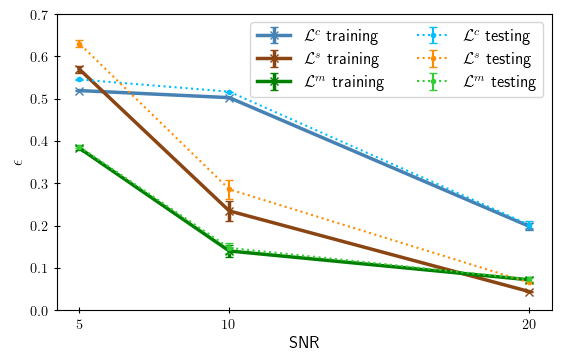

In [25]:
snr = [20,10,5]
plt.figure(figsize=(5.5,3.5))

plt.errorbar(snr,l_mean_classic[:,0],yerr=l_std_classic[:,0],label='$\mathcal{L}^c$ training',marker='x',color='steelblue',linewidth=2.5)
plt.errorbar(snr,l_mean_3[:,0],yerr=l_std_3[:,0],label='$\mathcal{L}^s$ training',marker='x',color='saddlebrown',linewidth=2.5)
plt.errorbar(snr,l_mean_mean3[:,0],yerr=l_std_mean3[:,0],label='$\mathcal{L}^m$ training',marker='x',color='green',linewidth=2.5)

plt.errorbar(snr,l_mean_classic[:,1],yerr=l_std_classic[:,1],label='$\mathcal{L}^c$ testing',marker='.',color='deepskyblue',linestyle=':')
plt.errorbar(snr,l_mean_3[:,1],yerr=l_std_3[:,1],label='$\mathcal{L}^s$ testing',marker='.',linestyle=':',color='darkorange')
plt.errorbar(snr,l_mean_mean3[:,1],yerr=l_std_mean3[:,1],label='$\mathcal{L}^m$ testing',marker='.',linestyle=':',color='limegreen',)

plt.legend(ncol=2,loc='upper right')
plt.ylabel('$\epsilon$')
plt.xticks([5,10,20])
plt.xlabel('SNR')
plt.ylim([0,0.7])
# plt.savefig('./figs/noisy_compare_lossfn')
plt.show()